# *k*-Armed-Bandits Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from env import *
from utils import *

plt.rcParams['figure.dpi'] = 300
k = 10
agents_num = 2000

def train_agents(agents, envs, **kwargs):
    testbed = list(zip(agents, envs))
    data = train(testbed, **kwargs)
    return data

### Stationary Environment

  0%|          | 9/2000 [00:00<00:24, 81.81it/s]

Epsilon: 0


  0%|          | 9/2000 [00:00<00:23, 84.33it/s]

Epsilon: 0.01


  0%|          | 9/2000 [00:00<00:22, 86.82it/s]

Epsilon: 0.1


100%|██████████| 2000/2000 [00:22<00:00, 89.24it/s]


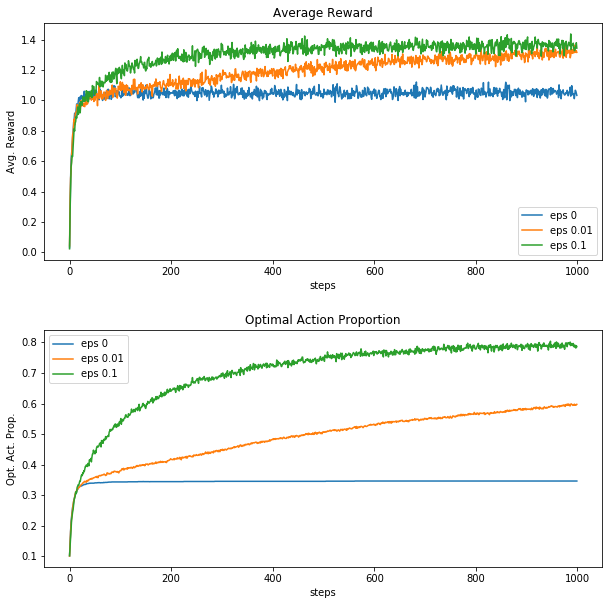

In [2]:
env = Env
agent = SampleAverage
data = dict()
eps = [0, 0.01, 0.1]

envs = [env(k) for _ in range(agents_num)]
for e in eps:
    print("Epsilon:", e)
    agents = [agent(k) for _ in range(agents_num)]
    data['eps {}'.format(e)] = train_agents(agents, envs, eps=e)
plot_data(data)

### Nonstationary Environment

#### Sample average

  0%|          | 4/2000 [00:00<00:50, 39.58it/s]

Epsilon: 0


  0%|          | 6/2000 [00:00<00:36, 54.47it/s]

Epsilon: 0.01


  0%|          | 6/2000 [00:00<00:36, 54.64it/s]

Epsilon: 0.1


100%|██████████| 2000/2000 [00:34<00:00, 58.01it/s]


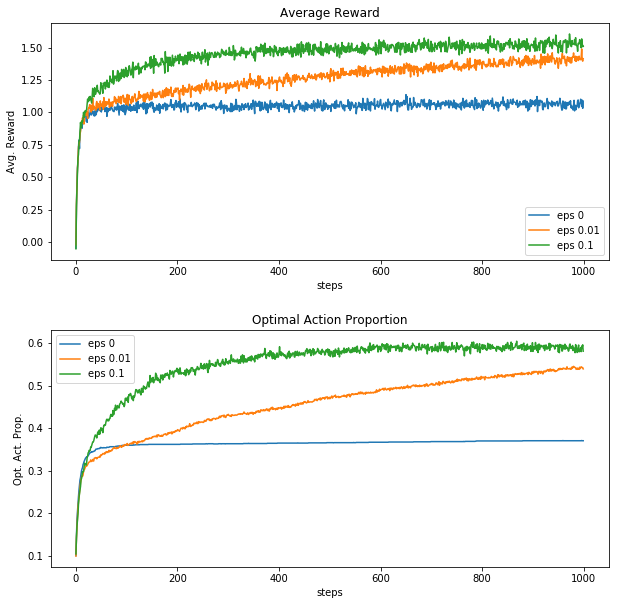

In [3]:
env = NonstationaryEnv
agent = SampleAverage
data = dict()
eps = [0, 0.01, 0.1]

envs = [env(k) for _ in range(agents_num)]
for e in eps:
    print("Epsilon:", e)
    agents = [agent(k) for _ in range(agents_num)]
    data['eps {}'.format(e)] = train_agents(agents, envs, eps=e)
plot_data(data)

#### Constant step size

  0%|          | 5/2000 [00:00<00:41, 48.64it/s]

Epsilon: 0


  0%|          | 6/2000 [00:00<00:37, 53.62it/s]

Epsilon: 0.01


  0%|          | 6/2000 [00:00<00:35, 55.64it/s]

Epsilon: 0.1


100%|██████████| 2000/2000 [00:34<00:00, 57.53it/s]


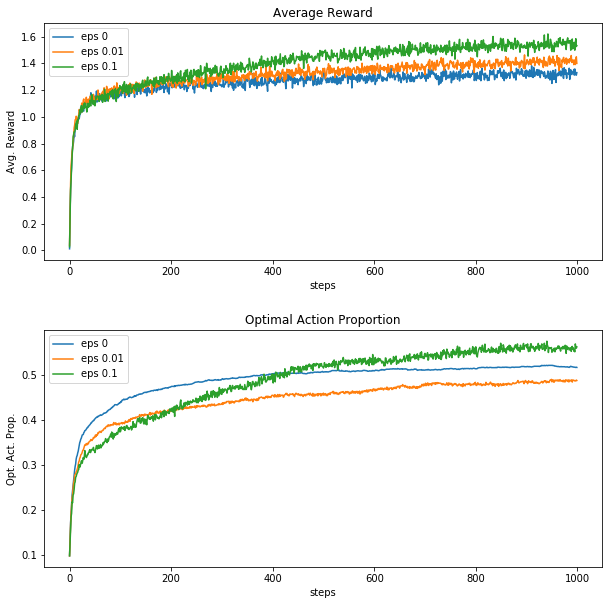

In [4]:
env = NonstationaryEnv
agent = ConstantStepSize
data = dict()
eps = [0, 0.01, 0.1]

envs = [env(k) for _ in range(agents_num)]
for e in eps:
    print("Epsilon:", e)
    agents = [agent(k, alpha=0.1) for _ in range(agents_num)] # alpha: step size
    data['eps {}'.format(e)] = train_agents(agents, envs, eps=e)
plot_data(data)

在环境是非静止的情况下，constant step size的更新比sample average要表现的更好，然而，sample average能消除constant step size带来的initial bias.s

### Unbiased Constant-Step-Size Trick

为了同时保留sample average和constant step size两者的优点，可以采用如下step size：

$$\beta_n \doteq \alpha \ / \ \bar{o}_n$$

来处理特定动作的第n个reward，其中，$\bar{o}_n$被定义为：

$$\bar{o}_n \doteq \bar{o}_{n-1} + \alpha \ (1 - \bar{o}_{n-1}),\ \mathrm{for}\ n \geq 0, \ \mathrm{with} \ \bar{o}_0 \doteq 0$$


  0%|          | 2/2000 [00:00<01:42, 19.58it/s]

Epsilon: 0


  0%|          | 3/2000 [00:00<01:24, 23.73it/s]

Epsilon: 0.01


  0%|          | 3/2000 [00:00<01:23, 23.86it/s]

Epsilon: 0.1


100%|██████████| 2000/2000 [01:15<00:00, 26.55it/s]


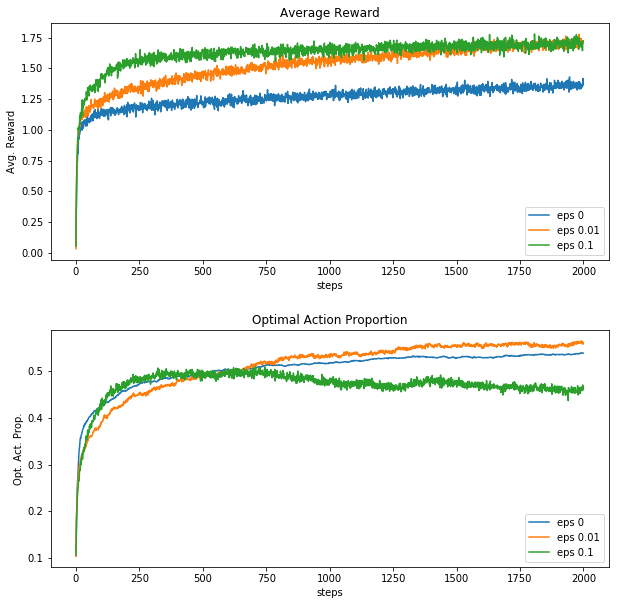

In [5]:
env = NonstationaryEnv
agent = UnbiasedConstantStepSize
data = dict()
eps = [0, 0.01, 0.1]

envs = [env(k) for _ in range(agents_num)]
for e in eps:
    print("Epsilon:", e)
    agents = [agent(k, alpha=0.1) for _ in range(agents_num)] # alpha: step size
    data['eps {}'.format(e)] = train_agents(agents, envs, eps=e, steps=2000)
plot_data(data)

### Optimistic Initial Values

分别将初始Q值设置为0或5

此方法不适合Nonstationary的情况，因为它的探索是暂时的

100%|██████████| 2000/2000 [00:22<00:00, 88.58it/s]


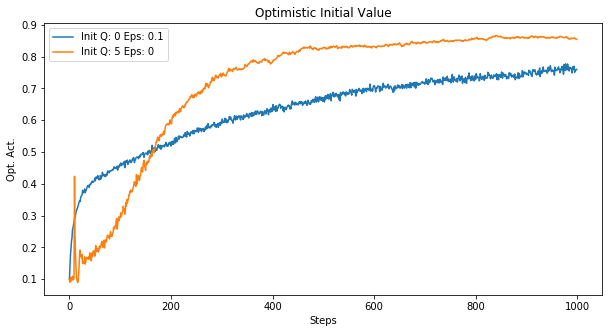

In [6]:
env = Env
agent = ConstantStepSize
data = dict()
kws = {
    "Init Q: 0 Eps: 0.1": {
        'init_q_value': 0,
        'eps': 0.1,
        'steps': 1000
    },
    "Init Q: 5 Eps: 0": {
        'init_q_value': 5,
        'eps': 0,
        'steps': 1000
    }
}

envs = [env(k) for _ in range(agents_num)]

for _k, _v in kws.items():
    agents = [agent(k, init_q_value=_v.get('init_q_value')) for _ in range(agents_num)]
    _v.pop('init_q_value')
    data[_k] = train_agents(agents, envs, **_v)

fig, ax = plt.subplots(figsize=(10, 5))
opt_prop_curve = cal_opt_prop(data)
plot_curve(data=opt_prop_curve, 
           ax=ax, 
           title='Optimistic Initial Value', 
           x_label='Steps', 
           y_label='Opt. Act.')
plt.show()

### Upper-Confidence-Bound (UCB) Action Selection

$\epsilon$-greedy能强制去探索那些non-greedy的动作，然而却不会偏好那些nearly greedy或者particularly uncertain的动作。选择动作时最好能在这些动作之中做出选择，一种有效的方法是使用如下的策略：

$$A_t \doteq \underset{a}{\mathrm{argmax}}\left[Q_t(a) + c \sqrt{\frac{\mathrm{ln}t}{N_t(a)}}  \right]$$

其中，$c$ 是探索率，$N_t(a)$ 是在 $t$ 时刻 $a$ 动作被采用的次数。在 $t$ 上采用自然对数是为了减缓其增长速度。

  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/c/Users/tan_z/OneDrive/Projects/reinforcement_learning/multi-armed_bandits/env.py:72: RuntimeWarning: invalid value encountered in true_divide
  np.divide(np.log(step), np.array(self._occur_times)))
/mnt/c/Users/tan_z/OneDrive/Projects/reinforcement_learning/multi-armed_bandits/env.py:72: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(np.log(step), np.array(self._occur_times)))
100%|██████████| 2000/2000 [00:24<00:00, 83.12it/s]


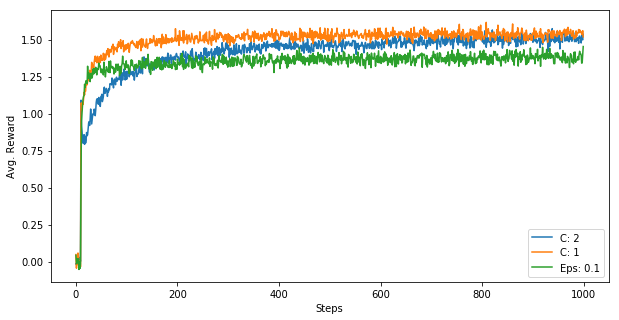

In [7]:
env = Env
agent = SampleAverage
data = dict()
kws = {
    "C: 2": {
        'init_q_value': 0,
        'eps': 0,
        'c': 2,
        'steps': 1000
    },
    "C: 1": {
        'init_q_value': 0,
        'eps': 0,
        'c': 1,
        'steps': 1000
    },
    "Eps: 0.1": {
        'init_q_value': 5,
        'eps': 0.1,
        'steps': 1000
    }
}

envs = [env(k) for _ in range(agents_num)]

for _k, _v in kws.items():
    agents = [agent(k, init_q_value=_v.get('init_q_value')) for _ in range(agents_num)]
    _v.pop('init_q_value')
    data[_k] = train_agents(agents, envs, **_v)

fig, ax = plt.subplots(figsize=(10, 5))
reward_curve = cal_reward(data)
plot_curve(data=reward_curve, 
           ax=ax, 
           title='', 
           x_label='Steps', 
           y_label='Avg. Reward')
plt.show()

100%|██████████| 2000/2000 [01:52<00:00, 18.08it/s]


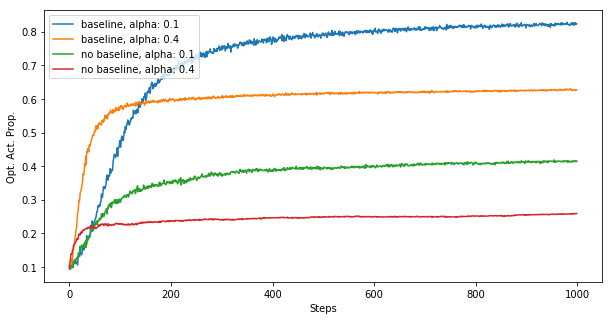

In [8]:
env = NonstationaryEnv
data = dict()
kws = {
    "baseline, alpha: 0.1": {
        'init_q_value': 0,
        'alpha': 0.1,
        'steps': 1000
    },
    "baseline, alpha: 0.4": {
        'init_q_value': 0,
        'alpha': 0.4,
        'steps': 1000
    }
}
kws_no_baseline = {
    "no baseline, alpha: 0.1": {
        'init_q_value': 0,
        'alpha': 0.1,
        'steps': 1000
    },
    "no baseline, alpha: 0.4": {
        'init_q_value': 0,
        'alpha': 0.4,
        'steps': 1000
    }
}

envs = [env(k, mean=4, var=1) for _ in range(agents_num)]

agent = GradientAscent
for _k, _v in kws.items():
    agents = [agent(k, 
                    init_q_value=_v.get('init_q_value'), 
                    alpha=_v.get('alpha')) for _ in range(agents_num)]
    _v.pop('init_q_value')
    _v.pop('alpha')
    data[_k] = train_agents(agents, envs, **_v)

# No baseline situation
agent = GradientAscentNoBaseline
for _k, _v in kws_no_baseline.items():
    agents = [agent(k, 
                    init_q_value=_v.get('init_q_value'), 
                    alpha=_v.get('alpha')) for _ in range(agents_num)]
    _v.pop('init_q_value')
    _v.pop('alpha')
    data[_k] = train_agents(agents, envs, **_v)

fig, ax = plt.subplots(figsize=(10, 5))
opt_prop_curve = cal_opt_prop(data)
plot_curve(data=opt_prop_curve, 
           ax=ax, 
           title='', 
           x_label='Steps', 
           y_label='Opt. Act. Prop.')
plt.show()
